# Prototypical Network

### Imports

In [ ]:
import os, glob, platform, random, json, copy
import numpy as np
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from contextlib import nullcontext
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from rad_dino import RadDino

from tqdm.auto import tqdm
from sklearn.metrics import (
    confusion_matrix, roc_curve, precision_recall_curve,
    roc_auc_score, average_precision_score, auc
)

import matplotlib.pyplot as plt

### Config

In [ ]:
# Configuración del dataset
DATA_ROOT   = "E:/TFM/Dataset_una_clase"   # {train,val,test}/{negative,positive}
IMAGE_SIZE  = 518
SEED        = 42

NUM_WORKERS = 0 if platform.system().lower().startswith("win") else 4

# Entrenamiento
N_WAY   = 2
N_SHOT  = 3
N_QUERY = 2

EPOCHS                = 40
WARMUP_EPOCHS         = 8
W_LR                  = 1e-3
FT_LR                 = 1e-4
WEIGHT_DECAY          = 1e-5
TEMPERATURE_INIT_INV  = 3.0
TRAIN_EPISODES_PER_EP = 50
VAL_EPISODES          = 100
OUT_DIR = "E:/TFM/modelos/Outputs_proto_Rad-Dino"

# Congelado encoder
FREEZE_ENCODER_IN_WARMUP   = True
FREEZE_ENCODER_IN_FINETUNE = True

# Estandarización por episodio
STANDARDIZE_EPISODE_TRAIN = True
STANDARDIZE_EPISODE_EVAL  = True

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Reproducibilidad
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed()
os.makedirs(OUT_DIR, exist_ok=True)

# Determinismo opcional
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Device: cuda


In [ ]:
def make_grad_scaler(device):
    if device.type != "cuda":
        return None
    if hasattr(torch, "amp"):
        for ctor in (lambda: torch.amp.GradScaler("cuda"),
                     lambda: torch.amp.GradScaler()):
            try:
                return ctor()
            except TypeError:
                continue
    try:
        return torch.cuda.amp.GradScaler()
    except Exception:
        return None

def autocast_ctx(device):
    if device.type != "cuda":
        return nullcontext()
    if hasattr(torch, "amp"):
        try:
            return torch.amp.autocast("cuda")
        except TypeError:
            return torch.amp.autocast(device_type="cuda")
        except Exception:
            return nullcontext()
    return torch.cuda.amp.autocast()                            

### Transforms

In [37]:
def _resize(img_size: int):
    return A.Resize(height=img_size, width=img_size)

def _random_resized_crop(img_size: int):
    try:
        return A.RandomResizedCrop(size=(img_size, img_size), scale=(0.9, 1.0), ratio=(0.9, 1.1), p=1.0)
    except TypeError:
        return A.RandomResizedCrop(height=img_size, width=img_size, scale=(0.9, 1.0), ratio=(0.9, 1.1), p=1.0)

train_tf_support = A.Compose([
    _random_resized_crop(IMAGE_SIZE),
    A.Affine(
        translate_percent={"x": (-0.03, 0.03), "y": (-0.03, 0.03)},
        scale=(0.95, 1.05),
        rotate=(-5, 5),
        interpolation=cv2.INTER_LINEAR,
        border_mode=cv2.BORDER_CONSTANT,
        p=0.7
    ),
    A.RandomBrightnessContrast(0.05, 0.05, p=0.5),
    ToTensorV2(),
])

eval_tf = A.Compose([
    _resize(IMAGE_SIZE),
    ToTensorV2(),
])

### Dataset

In [38]:
class ChestXrayDataset(Dataset):
    def __init__(self, root_split_dir, transform=None):
        self.root = root_split_dir
        self.transform = transform
        self.class_to_idx = {"negative": 0, "positive": 1}
        self.samples = []

        exts = ("*.png", "*.jpg", "*.jpeg", "*.bmp", "*.tif", "*.tiff")
        for cls in ["negative", "positive"]:
            for ext in exts:
                for f in glob.glob(os.path.join(self.root, cls, ext)):
                    self.samples.append((f, self.class_to_idx[cls]))

        # filtrar ilegibles
        valid, skipped = [], []
        for path, label in self.samples:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None or img.size == 0:
                skipped.append(path)
            else:
                valid.append((path, label))
        if skipped:
            print(f"[WARN] {len(skipped)} imágenes ilegibles en {self.root}, se omiten.")
        self.samples = valid
        if len(self.samples) == 0:
            raise RuntimeError(f"No hay imágenes válidas en {self.root}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        if self.transform:
            img = self.transform(image=img)["image"]
        return img, torch.tensor(label, dtype=torch.long)

def make_base_splits():
    train_ds = ChestXrayDataset(os.path.join(DATA_ROOT, "train"), transform=None)  # transforms en episodios
    val_ds   = ChestXrayDataset(os.path.join(DATA_ROOT, "val"),   transform=None)
    test_ds  = ChestXrayDataset(os.path.join(DATA_ROOT, "test"),  transform=None)
    print(f"Base splits -> Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = make_base_splits()

Base splits -> Train: 30 | Val: 10 | Test: 10


### Encoder (Backbone) + Proto Head

In [ ]:
class RadDinoProtoEncoder(nn.Module):
    def __init__(self, proj_dim=256, hidden=512, dropout=0.2, normalize=True):
        super().__init__()
        self.encoder = RadDino()
        self.out_dim = 768
        self.proj = nn.Sequential(
            nn.Linear(self.out_dim, hidden),
            nn.GELU(),
            nn.LayerNorm(hidden),
            nn.Dropout(dropout),
            nn.Linear(hidden, proj_dim),
            nn.LayerNorm(proj_dim),
        )
        self.emb_dim = proj_dim
        self.normalize = normalize
        self._supports_tensor_forward = hasattr(self.encoder, "forward")

    def _encode_batch_fallback(self, x):
        feats = []
        for img in x:
            pil = TF.to_pil_image(img.detach().cpu().clamp(0, 1))
            cls, _ = self.encoder.extract_features(pil)  # [1,768]
            feats.append(cls.squeeze(0))
        return torch.stack(feats, dim=0).to(x.device)  # [B,768]

    def forward(self, x):  # x: [B,3,H,W], float32 en [0,1] normalizado
        if self._supports_tensor_forward:
            enc_out = self.encoder(x)
            if isinstance(enc_out, (tuple, list)):
                feats = enc_out[0]
            elif isinstance(enc_out, dict):
                feats = enc_out.get("cls", None)
                if feats is None:
                    for k in ["pooled", "feat", "features", "x"]:
                        if k in enc_out:
                            feats = enc_out[k]
                            break
                if feats is None:
                    raise RuntimeError("No pude encontrar la salida CLS en el dict de RadDino.forward")
            else:
                feats = enc_out
            if feats.dim() == 3:
                feats = feats[:, 0, :]
        else:
            feats = self._encode_batch_fallback(x)

        z = self.proj(feats)
        if self.normalize:
            z = F.normalize(z, dim=1)
        return z

In [40]:
class ProtoHead(nn.Module):
    def __init__(self, init_inv_temp=TEMPERATURE_INIT_INV, metric="cosine"):
        super().__init__()
        self.logit_scale = nn.Parameter(torch.tensor(float(np.log(init_inv_temp)), dtype=torch.float32))
        self.metric = metric

    def forward(self, emb_support: torch.Tensor, emb_query: torch.Tensor,
                y_query: torch.Tensor, n_way: int, n_shot: int):
        protos = []
        for c in range(n_way):
            idx = slice(c * n_shot, (c + 1) * n_shot)
            protos.append(emb_support[idx].mean(0))
        protos = torch.stack(protos, 0)  # [K,D]

        inv_temp = self.logit_scale.exp().clamp(0.1, 50.0)

        if self.metric == "cosine":
            q = F.normalize(emb_query, dim=1)
            p = F.normalize(protos,    dim=1)
            logits = q @ p.t()
            logits = logits * inv_temp
        else:
            q = emb_query.unsqueeze(1)   # [Q,1,D]
            p = protos.unsqueeze(0)      # [1,K,D]
            d2 = ((q - p) ** 2).sum(-1)  # [Q,K]
            logits = -d2 * inv_temp

        loss = F.cross_entropy(logits, y_query)
        acc = (logits.argmax(1) == y_query).float().mean()
        return loss, acc, logits

In [ ]:
class EpisodicFewShotDataset(Dataset):
    def __init__(self, base_ds, n_way=2, n_shot=5, n_query=15, n_episodes=1000,
                 transform_support=None, transform_query=None, seed=123):
        self.ds = base_ds
        self.n_way = n_way
        self.n_shot = n_shot
        self.n_query = n_query
        self.n_episodes = n_episodes
        self.rng = np.random.default_rng(seed)
        self.transform_support = transform_support
        self.transform_query   = transform_query

        # índice por clase
        self.class_to_idx = defaultdict(list)
        for i, (path, lab) in enumerate(self.ds.samples):
            self.class_to_idx[int(lab)].append(i)
        self.class_to_idx = {k: np.array(v, dtype=np.int64) for k, v in self.class_to_idx.items()}
        assert len(self.class_to_idx) >= n_way, "No hay suficientes clases para N-way."

    def __len__(self):
        return self.n_episodes

    def _get_img(self, idx, transform):
        path, _ = self.ds.samples[idx]
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        if transform:
            img = transform(image=img)["image"]
        return img

    def __getitem__(self, _):
        # si es binario {0,1}, fija el orden -> 0=negative,1=positive; si no, samplea
        if self.n_way == 2 and set(self.class_to_idx.keys()) == {0,1}:
            classes = [0,1]
        else:
            classes = self.rng.choice(list(self.class_to_idx.keys()), size=self.n_way, replace=False).tolist()

        S_imgs, Q_imgs, Q_labels = [], [], []

        for epi_c, real_c in enumerate(classes):
            ids = self.class_to_idx[real_c]
            need = self.n_shot + self.n_query
            assert len(ids) >= need, f"Clase {real_c} no tiene {need} ejemplos"
            pick = self.rng.choice(ids, size=need, replace=False)

            for idx in pick[:self.n_shot]:
                S_imgs.append(self._get_img(idx, self.transform_support))
            for idx in pick[self.n_shot:]:
                Q_imgs.append(self._get_img(idx, self.transform_query))
                Q_labels.append(epi_c)

        S = torch.stack(S_imgs, 0)  # [n_way*n_shot, 3,H,W]
        Q = torch.stack(Q_imgs, 0)  # [n_way*n_query, 3,H,W]
        yq = torch.tensor(Q_labels, dtype=torch.long)
        return {"support": S, "query": Q, "yq": yq}

In [ ]:
def build_class_index(ds):
    d = defaultdict(list)
    for i, (_, lab) in enumerate(ds.samples):
        d[int(lab)].append(i)
    return {k: np.array(v, dtype=np.int64) for k, v in d.items()}

@torch.no_grad()
def encode_images(model, idxs, ds, transform, device, batch=32, show_progress=True):
    model.eval()
    out = []
    iterator = range(0, len(idxs), batch)
    if show_progress:
        iterator = tqdm(iterator, total=(len(idxs)+batch-1)//batch,
                        desc="Encoding images (batches)", leave=False, dynamic_ncols=True)
    for i in iterator:
        batch_idxs = idxs[i:i+batch]
        imgs = []
        for j in batch_idxs:
            path, _ = ds.samples[j]
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            img = transform(image=img)["image"]
            imgs.append(img)
        x = torch.stack(imgs, 0).to(device)
        feats = model(x)  # [B,D]
        out.append(feats.detach().cpu())
    return torch.cat(out, 0)  # [N,D]

def get_param_groups_for_adamw(model, extra_params=(), weight_decay=WEIGHT_DECAY):
    decay, no_decay = [], []
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if name.endswith(".bias") or "LayerNorm" in name or "layernorm" in name or "ln" in name:
            no_decay.append(p)
        else:
            decay.append(p)
    for p in extra_params:
        if p.requires_grad:
            no_decay.append(p) if p.ndim == 1 else decay.append(p)
    return [
        {"params": decay, "weight_decay": weight_decay},
        {"params": no_decay, "weight_decay": 0.0},
    ]

def episode_standardize(x, enabled: bool):
    if not enabled:
        return x
    m = x.mean(0, keepdim=True)
    s = x.std(0, unbiased=False, keepdim=True).clamp_min(1e-6)
    return (x - m) / s

### Entrenamiento

In [ ]:
def train_protonet(
    train_base_ds, val_base_ds,
    n_way=2, n_shot=5, n_query=15,
    train_episodes_per_epoch=200,
    val_episodes=400,
    epochs=40, warmup_epochs=8,
    w_lr=1e-3, ft_lr=5e-4, weight_decay=1e-5,
    standardize_episode=STANDARDIZE_EPISODE_TRAIN,
    out_dir="E:/TFM/modelos/Outputs_Proto_Rad-Dino",
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
):
    os.makedirs(out_dir, exist_ok=True)

    # Dataset episódico
    train_epi = EpisodicFewShotDataset(
        train_base_ds, n_way, n_shot, n_query,
        n_episodes=train_episodes_per_epoch*epochs,
        transform_support=train_tf_support, transform_query=eval_tf,
        seed=SEED
    )
    val_epi = EpisodicFewShotDataset(
        val_base_ds, n_way, n_shot, n_query,
        n_episodes=val_episodes,
        transform_support=eval_tf, transform_query=eval_tf,
        seed=SEED+1
    )

    pin = (device.type == "cuda")
    train_loader = DataLoader(train_epi, batch_size=1, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=pin)
    val_loader   = DataLoader(val_epi,   batch_size=1, shuffle=False, num_workers=NUM_WORKERS, pin_memory=pin)

    # Modelo + cabeza
    model = RadDinoProtoEncoder().to(device)
    proto_head = ProtoHead(init_inv_temp=TEMPERATURE_INIT_INV, metric="cosine").to(device)

    # congelado del encoder según fase
    def set_frozen_encoder(frozen: bool):
        for n, p in model.named_parameters():
            if n.startswith("encoder."):
                p.requires_grad = not frozen
            else:
                p.requires_grad = True

    # -------- Warm-up --------
    set_frozen_encoder(FREEZE_ENCODER_IN_WARMUP)

    def make_opt(lr):
        groups = get_param_groups_for_adamw(model, extra_params=list(proto_head.parameters()), weight_decay=weight_decay)
        return optim.AdamW(groups, lr=lr)

    opt = make_opt(w_lr)
    sch = None
    scaler = make_grad_scaler(device)

    best_val_acc, best_state_model, best_state_head = -1.0, None, None

    for ep in range(warmup_epochs):
        model.train()
        proto_head.train()
        losses, accs = [], []
        pbar = tqdm(range(train_episodes_per_epoch), desc=f"Proto Warmup {ep+1}/{warmup_epochs}")
        it = iter(train_loader)
        for _ in pbar:
            batch = next(it)
            S = batch["support"].squeeze(0).to(device)
            Q = batch["query"].squeeze(0).to(device)
            yq = batch["yq"].squeeze(0).to(device)

            opt.zero_grad(set_to_none=True)
            if scaler:
                with autocast_ctx(device):
                    emb_S = episode_standardize(model(S), standardize_episode)
                    emb_Q = episode_standardize(model(Q), standardize_episode)
                    loss, acc, _ = proto_head(emb_S, emb_Q, yq, n_way, n_shot)
                scaler.scale(loss).backward()
                scaler.step(opt)
                scaler.update()
            else:
                emb_S = episode_standardize(model(S), standardize_episode)
                emb_Q = episode_standardize(model(Q), standardize_episode)
                loss, acc, _ = proto_head(emb_S, emb_Q, yq, n_way, n_shot)
                loss.backward()
                opt.step()

            losses.append(loss.item())
            accs.append(acc.item())
            pbar.set_postfix(loss=np.mean(losses), acc=np.mean(accs))

        # validación
        model.eval()
        proto_head.eval()
        accs_val = []
        with torch.no_grad():
            for batch in val_loader:
                S = batch["support"].squeeze(0).to(device)
                Q = batch["query"].squeeze(0).to(device)
                yq = batch["yq"].squeeze(0).to(device)
                emb_S = episode_standardize(model(S), standardize_episode)
                emb_Q = episode_standardize(model(Q), standardize_episode)
                _, acc, _ = proto_head(emb_S, emb_Q, yq, n_way, n_shot)
                accs_val.append(acc.item())
        mean_val = float(np.mean(accs_val)) if accs_val else 0.0
        print(f"[Warmup {ep+1}] val episodic acc: {mean_val:.4f}")
        if mean_val > best_val_acc:
            best_val_acc = mean_val
            best_state_model = copy.deepcopy(model.state_dict())
            best_state_head  = copy.deepcopy(proto_head.state_dict())
            torch.save(best_state_model, os.path.join(out_dir, "best_proto_warmup_model.pt"))
            torch.save(best_state_head,  os.path.join(out_dir, "best_proto_warmup_head.pt"))

    # -------- Fine-tune --------
    set_frozen_encoder(FREEZE_ENCODER_IN_FINETUNE)
    opt = make_opt(ft_lr)
    sch = CosineAnnealingLR(opt, T_max=max(1, epochs - warmup_epochs))

    for ep in range(warmup_epochs, epochs):
        model.train()
        proto_head.train()
        losses, accs = [], []
        pbar = tqdm(range(train_episodes_per_epoch), desc=f"Proto FT {ep+1}/{epochs}")
        it = iter(train_loader)
        for _ in pbar:
            batch = next(it)
            S = batch["support"].squeeze(0).to(device)
            Q = batch["query"].squeeze(0).to(device)
            yq = batch["yq"].squeeze(0).to(device)

            opt.zero_grad(set_to_none=True)
            if scaler:
                with autocast_ctx(device):
                    emb_S = episode_standardize(model(S), standardize_episode)
                    emb_Q = episode_standardize(model(Q), standardize_episode)
                    loss, acc, _ = proto_head(emb_S, emb_Q, yq, n_way, n_shot)
                scaler.scale(loss).backward()
                scaler.step(opt)
                scaler.update()
            else:
                emb_S = episode_standardize(model(S), standardize_episode)
                emb_Q = episode_standardize(model(Q), standardize_episode)
                loss, acc, _ = proto_head(emb_S, emb_Q, yq, n_way, n_shot)
                loss.backward()
                opt.step()

            losses.append(loss.item())
            accs.append(acc.item())
            pbar.set_postfix(loss=np.mean(losses), acc=np.mean(accs))

        if sch is not None:
            sch.step()

        # validación
        model.eval()
        proto_head.eval()
        accs_val = []
        with torch.no_grad():
            for batch in val_loader:
                S = batch["support"].squeeze(0).to(device)
                Q = batch["query"].squeeze(0).to(device)
                yq = batch["yq"].squeeze(0).to(device)
                emb_S = episode_standardize(model(S), standardize_episode)
                emb_Q = episode_standardize(model(Q), standardize_episode)
                _, acc, _ = proto_head(emb_S, emb_Q, yq, n_way, n_shot)
                accs_val.append(acc.item())
        mean_val = float(np.mean(accs_val)) if accs_val else 0.0
        print(f"[FT {ep+1}] val episodic acc: {mean_val:.4f}")
        if mean_val > best_val_acc:
            best_val_acc = mean_val
            best_state_model = copy.deepcopy(model.state_dict())
            best_state_head  = copy.deepcopy(proto_head.state_dict())
            torch.save(best_state_model, os.path.join(out_dir, "best_proto_model.pt"))
            torch.save(best_state_head,  os.path.join(out_dir, "best_proto_head.pt"))

    if best_state_model is not None:
        model.load_state_dict(best_state_model)
    if best_state_head is not None:
        proto_head.load_state_dict(best_state_head)

    with open(os.path.join(out_dir, "train_summary.json"), "w") as f:
        json.dump({"best_val_acc": best_val_acc}, f, indent=2)

    return model, proto_head

In [44]:
proto_model, proto_head = train_protonet(
    train_base_ds=train_ds, val_base_ds=val_ds,
    n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY,
    train_episodes_per_epoch=TRAIN_EPISODES_PER_EP,
    val_episodes=VAL_EPISODES,
    epochs=EPOCHS, warmup_epochs=WARMUP_EPOCHS,
    w_lr=W_LR, ft_lr=FT_LR, weight_decay=WEIGHT_DECAY,
    standardize_episode=STANDARDIZE_EPISODE_TRAIN,
    out_dir=OUT_DIR, device=device
)

Proto Warmup 1/8: 100%|██████████| 50/50 [01:06<00:00,  1.33s/it, acc=0.945, loss=0.103]


[Warmup 1] val episodic acc: 0.8225


Proto Warmup 2/8: 100%|██████████| 50/50 [01:02<00:00,  1.24s/it, acc=1, loss=0.00623]


[Warmup 2] val episodic acc: 0.8475


Proto Warmup 3/8: 100%|██████████| 50/50 [01:02<00:00,  1.26s/it, acc=1, loss=0.00404]


[Warmup 3] val episodic acc: 0.8075


Proto Warmup 4/8: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it, acc=1, loss=0.00316]


[Warmup 4] val episodic acc: 0.8150


Proto Warmup 5/8: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it, acc=1, loss=0.00257]


[Warmup 5] val episodic acc: 0.8025


Proto Warmup 6/8: 100%|██████████| 50/50 [01:01<00:00,  1.24s/it, acc=1, loss=0.00221]


[Warmup 6] val episodic acc: 0.8025


Proto Warmup 7/8: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it, acc=1, loss=0.0019] 


[Warmup 7] val episodic acc: 0.8550


Proto Warmup 8/8: 100%|██████████| 50/50 [01:01<00:00,  1.24s/it, acc=1, loss=0.0017] 


[Warmup 8] val episodic acc: 0.8400


Proto FT 9/40: 100%|██████████| 50/50 [01:02<00:00,  1.24s/it, acc=1, loss=0.00129]


[FT 9] val episodic acc: 0.8300


Proto FT 10/40: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it, acc=1, loss=0.0011] 


[FT 10] val episodic acc: 0.8475


Proto FT 11/40: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it, acc=1, loss=0.00103]


[FT 11] val episodic acc: 0.8475


Proto FT 12/40: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it, acc=1, loss=0.000984]


[FT 12] val episodic acc: 0.8500


Proto FT 13/40: 100%|██████████| 50/50 [01:01<00:00,  1.24s/it, acc=1, loss=0.000946]


[FT 13] val episodic acc: 0.8625


Proto FT 14/40: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it, acc=1, loss=0.000916]


[FT 14] val episodic acc: 0.8250


Proto FT 15/40: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it, acc=1, loss=0.000884]


[FT 15] val episodic acc: 0.8475


Proto FT 16/40: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it, acc=1, loss=0.000858]


[FT 16] val episodic acc: 0.8175


Proto FT 17/40: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it, acc=1, loss=0.000833]


[FT 17] val episodic acc: 0.8525


Proto FT 18/40: 100%|██████████| 50/50 [01:01<00:00,  1.24s/it, acc=1, loss=0.00081] 


[FT 18] val episodic acc: 0.8450


Proto FT 19/40: 100%|██████████| 50/50 [01:01<00:00,  1.24s/it, acc=1, loss=0.00079] 


[FT 19] val episodic acc: 0.8200


Proto FT 20/40: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it, acc=1, loss=0.000771]


[FT 20] val episodic acc: 0.8225


Proto FT 21/40: 100%|██████████| 50/50 [01:01<00:00,  1.24s/it, acc=1, loss=0.000755]


[FT 21] val episodic acc: 0.8400


Proto FT 22/40: 100%|██████████| 50/50 [01:01<00:00,  1.24s/it, acc=1, loss=0.000739]


[FT 22] val episodic acc: 0.8550


Proto FT 23/40: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it, acc=1, loss=0.000724]


[FT 23] val episodic acc: 0.8475


Proto FT 24/40: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it, acc=1, loss=0.000712]


[FT 24] val episodic acc: 0.8750


Proto FT 25/40: 100%|██████████| 50/50 [01:01<00:00,  1.24s/it, acc=1, loss=0.0007]  


[FT 25] val episodic acc: 0.8225


Proto FT 26/40: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it, acc=1, loss=0.00069] 


[FT 26] val episodic acc: 0.8475


Proto FT 27/40: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it, acc=1, loss=0.00068] 


[FT 27] val episodic acc: 0.8775


Proto FT 28/40: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it, acc=1, loss=0.000672]


[FT 28] val episodic acc: 0.8500


Proto FT 29/40: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it, acc=1, loss=0.000665]


[FT 29] val episodic acc: 0.8750


Proto FT 30/40: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it, acc=1, loss=0.000659]


[FT 30] val episodic acc: 0.8775


Proto FT 31/40: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it, acc=1, loss=0.000654]


[FT 31] val episodic acc: 0.8175


Proto FT 32/40: 100%|██████████| 50/50 [01:03<00:00,  1.26s/it, acc=1, loss=0.00065] 


[FT 32] val episodic acc: 0.8925


Proto FT 33/40: 100%|██████████| 50/50 [01:02<00:00,  1.24s/it, acc=1, loss=0.000646]


[FT 33] val episodic acc: 0.8775


Proto FT 34/40: 100%|██████████| 50/50 [01:03<00:00,  1.26s/it, acc=1, loss=0.000643]


[FT 34] val episodic acc: 0.8650


Proto FT 35/40: 100%|██████████| 50/50 [01:01<00:00,  1.24s/it, acc=1, loss=0.000642]


[FT 35] val episodic acc: 0.8575


Proto FT 36/40: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it, acc=1, loss=0.00064]


[FT 36] val episodic acc: 0.9025


Proto FT 37/40: 100%|██████████| 50/50 [01:02<00:00,  1.26s/it, acc=1, loss=0.00064] 


[FT 37] val episodic acc: 0.8575


Proto FT 38/40: 100%|██████████| 50/50 [01:02<00:00,  1.24s/it, acc=1, loss=0.000638]


[FT 38] val episodic acc: 0.8825


Proto FT 39/40: 100%|██████████| 50/50 [01:02<00:00,  1.24s/it, acc=1, loss=0.000637]


[FT 39] val episodic acc: 0.8575


Proto FT 40/40: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it, acc=1, loss=0.000637]


[FT 40] val episodic acc: 0.8550


### Evaluación

In [ ]:
@torch.no_grad()
def run_fewshot_eval_PROTO(
    model, ds, device,
    n_way=2, n_shot=5, n_query=15, n_episodes=200,
    seed=123, show_progress=True,
    proto_head=None,
    standardize_episode: bool = STANDARDIZE_EPISODE_EVAL
):
    rng = np.random.default_rng(seed)
    cls_index = build_class_index(ds)

    # temperatura desde la head (cosine) si está disponible
    inv_temp = None
    if proto_head is not None:
        inv_temp = float(proto_head.logit_scale.exp().item())
    if inv_temp is None:
        inv_temp = TEMPERATURE_INIT_INV
    inv_temp = max(0.1, min(50.0, inv_temp))

    # precomputar embeddings por clase
    per_class_feats = {}
    for c, idxs in tqdm(cls_index.items(), total=len(cls_index),
                        desc="Precomputing class embeddings", leave=False, dynamic_ncols=True):
        feats_c = encode_images(model, idxs.tolist(), ds, eval_tf, device, batch=32, show_progress=False)
        per_class_feats[c] = feats_c  # [Nc,D] CPU

    def ep_std(x: torch.Tensor) -> torch.Tensor:
        return episode_standardize(x, standardize_episode)

    accs = []
    all_y_true, all_y_pred, all_pos_scores = [], [], []

    iterator = range(n_episodes)
    if show_progress:
        iterator = tqdm(iterator, total=n_episodes, desc=f"{n_way}-way {n_shot}-shot", leave=False, dynamic_ncols=True)

    for epi in iterator:
        if n_way == 2 and set(cls_index.keys()) == {0,1}:
            classes = [0,1]  # orden fijo -> 0=negative, 1=positive
        else:
            classes = rng.choice(list(cls_index.keys()), size=n_way, replace=False).tolist()

        S_feats, Q_feats, Q_labels = [], [], []
        for epi_c, real_c in enumerate(classes):
            feats_c = per_class_feats[real_c]  # [Nc,D] CPU
            Nc = feats_c.shape[0]
            need = n_shot + n_query
            assert Nc >= need, f"Clase {real_c} no tiene {need} ejemplos"
            picks = rng.choice(Nc, size=need, replace=False)
            S_feats.append(feats_c[picks[:n_shot]])
            Q_feats.append(feats_c[picks[n_shot:]])
            Q_labels.append(np.full(n_query, epi_c, dtype=np.int64))

        S_feats = torch.cat(S_feats, 0).to(device)   # [K*n_shot, D]
        Q_feats = torch.cat(Q_feats, 0).to(device)   # [K*n_query, D]
        Q_labels = torch.from_numpy(np.concatenate(Q_labels)).to(device)

        S_feats = ep_std(S_feats)
        Q_feats = ep_std(Q_feats)

        # Prototipos y logits (métrica coseno con inv_temp)
        protos = []
        for c in range(n_way):
            idx_c = slice(c * n_shot, (c + 1) * n_shot)
            protos.append(S_feats[idx_c].mean(0))
        protos = torch.stack(protos, 0)                 # [K,D]
        q = F.normalize(Q_feats, dim=1)
        p = F.normalize(protos,  dim=1)
        logits = (q @ p.t()) * inv_temp
        probs_epi = torch.softmax(logits, dim=1)        # [Q,K]

        preds = logits.argmax(dim=1).cpu().numpy()
        yq_np = Q_labels.cpu().numpy()
        accs.append((preds == yq_np).mean())

        all_y_true.extend(yq_np.tolist())
        all_y_pred.extend(preds.tolist())
        if n_way == 2:
            all_pos_scores.extend(probs_epi[:, 1].detach().cpu().numpy().tolist())

        if show_progress:
            iterator.set_postfix(acc_mean=f"{np.mean(accs):.3f}", epi=epi + 1)

    accs = np.array(accs, dtype=np.float64)
    std = accs.std(ddof=1) if len(accs) > 1 else 0.0
    ci = 1.96 * std / np.sqrt(len(accs)) if len(accs) > 0 else 0.0

    out = {
        "episodes": int(n_episodes),
        "n_way": int(n_way),
        "n_shot": int(n_shot),
        "n_query": int(n_query),
        "acc_mean": float(accs.mean()) if len(accs) > 0 else 0.0,
        "acc_std": float(std),
        "acc_95ci_halfwidth": float(ci),
        "y_true": all_y_true,
        "y_pred": all_y_pred,
        "episode_accs": accs.tolist(),
        "inv_temp_used": float(inv_temp),
    }
    if n_way == 2:
        out["pos_scores"] = all_pos_scores
    return out

In [ ]:
def plot_confusion(cm, class_names=None, title="Matriz de confusión"):
    plt.figure(figsize=(4.5, 4))
    im = plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_marks = np.arange(cm.shape[0])
    if class_names is None:
        class_names = [str(i) for i in range(cm.shape[0])]
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2.0 if cm.size > 0 else 0.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Real')
    plt.xlabel('Predicción')
    plt.tight_layout()
    plt.show()

def plot_confusion_percent(cm, class_names=None, title="Matriz de confusión (%)", normalize="row"):
    cm = np.asarray(cm)
    C = cm.shape[0]
    if class_names is None:
        class_names = [str(i) for i in range(C)]

    if normalize == "row":
        denom = cm.sum(axis=1, keepdims=True)
    elif normalize == "col":
        denom = cm.sum(axis=0, keepdims=True).T
    elif normalize == "all":
        denom = np.full_like(cm, cm.sum())
    else:
        raise ValueError('normalize debe ser "row", "col" o "all"')

    denom = np.clip(denom, a_min=1, a_max=None)
    cm_norm = cm.astype(float) / denom

    plt.figure(figsize=(4.8, 4))
    im = plt.imshow(cm_norm, interpolation='nearest', vmin=0, vmax=1)
    plt.title(title)
    plt.xticks(range(C), class_names, rotation=45, ha='right')
    plt.yticks(range(C), class_names)

    for i in range(C):
        for j in range(C):
            plt.text(j, i, f"{cm_norm[i, j]*100:.1f}%", ha="center", va="center",
                     color="white" if cm_norm[i, j] > 0.5 else "black")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

def plot_hist_acc(episode_accs, title="Distribución de accuracy por episodio"):
    plt.figure(figsize=(5, 3.2))
    plt.hist(episode_accs, bins=20, edgecolor='black')
    plt.title(title)
    plt.xlabel("Accuracy")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

def plot_roc_pr(y_true, pos_scores):
    fpr, tpr, _ = roc_curve(y_true, pos_scores)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_true, pos_scores)
    ap = average_precision_score(y_true, pos_scores)

    plt.figure(figsize=(4.8, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC (binario)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(4.8, 4))
    plt.plot(recall, precision, label=f"AP = {ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall (binario)")
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()

def find_threshold_for_spec(scores, targets, target_spec=0.95, show_progress=False):
    ts = np.linspace(0,1,1001)
    best = {"thr": 0.5, "sens": 0.0, "spec": 0.0}
    iterator = tqdm(ts, desc=f"Search thr @spec≥{target_spec}", leave=False, dynamic_ncols=True) if show_progress else ts
    for t in iterator:
        preds = (scores >= t).astype(np.int64)
        tn, fp, fn, tp = confusion_matrix(targets, preds, labels=[0,1]).ravel()
        spec = tn/(tn+fp) if (tn+fp)>0 else 0.0
        sens = tp/(tp+fn) if (tp+fn)>0 else 0.0
        if spec >= target_spec and sens > best["sens"]:
            best = {"thr": float(t), "sens": float(sens), "spec": float(spec)}
    return best

def find_threshold_max_f1(scores, targets, show_progress=False):
    ts = np.linspace(0,1,1001)
    best = {"thr": 0.5, "f1": 0.0}
    iterator = tqdm(ts, desc="Search thr @max F1", leave=False, dynamic_ncols=True) if show_progress else ts
    for t in iterator:
        preds = (scores >= t).astype(np.int64)
        tp = np.sum((preds==1) & (targets==1))
        fp = np.sum((preds==1) & (targets==0))
        fn = np.sum((preds==0) & (targets==1))
        f1 = (2*tp)/(2*tp+fp+fn) if (2*tp+fp+fn)>0 else 0.0
        if f1 > best["f1"]:
            best = {"thr": float(t), "f1": float(f1)}
    return best

def evaluate_with_threshold(scores, targets, thr):
    preds = (scores >= thr).astype(np.int64)
    tn, fp, fn, tp = confusion_matrix(targets, preds, labels=[0,1]).ravel()
    acc  = (tp+tn)/(tp+tn+fp+fn)
    spec = tn/(tn+fp) if (tn+fp)>0 else 0.0
    sens = tp/(tp+fn) if (tp+fn)>0 else 0.0
    f1   = (2*tp)/(2*tp+fp+fn) if (2*tp+fp+fn)>0 else 0.0
    return {"acc":acc, "sens":sens, "spec":spec, "f1":f1, "tp":tp, "fp":fp, "tn":tn, "fn":fn}



=== Few-shot evaluation (ProtoNet encoder + ProtoHead coseno) ===


VAL  (k=2, n=1): {'episodes': 500, 'n_way': 2, 'n_shot': 1, 'n_query': 4, 'acc_mean': 0.70125, 'acc_std': 0.2234772284669885, 'acc_95ci_halfwidth': 0.019588642751597145, 'inv_temp_used': 3.683858633041382}
TEST (k=2, n=1): {'episodes': 500, 'n_way': 2, 'n_shot': 1, 'n_query': 4, 'acc_mean': 0.4755, 'acc_std': 0.1947128042844245, 'acc_95ci_halfwidth': 0.01706732980560775, 'inv_temp_used': 3.683858633041382}
inv_temp usado (VAL):  3.683858633041382
inv_temp usado (TEST): 3.683858633041382
Umbral ~95% espec (VAL): {'thr': 0.5, 'sens': 0.0, 'spec': 0.0}
Umbral máx F1 (VAL):      {'thr': 0.073, 'f1': 0.8023549201009251}

TEST @ thr(95spec en VAL): {'acc': np.float64(0.4755), 'sens': np.float64(0.508), 'spec': np.float64(0.443), 'f1': np.float64(0.4920096852300242), 'tp': np.int64(1016), 'fp': np.int64(1114), 'tn': np.int64(886), 'fn': np.int64(984)}

TEST @ thr(maxF1 en VAL): {'acc': np.float64(0.4985), 'sens': np.float64(0.8405), 'spec': np.float64(0.1565), 'f1': np.float64(0.6263040238450

VAL  (k=2, n=2): {'episodes': 500, 'n_way': 2, 'n_shot': 2, 'n_query': 3, 'acc_mean': 0.8056666666666666, 'acc_std': 0.12862901765036042, 'acc_95ci_halfwidth': 0.011274830511932865, 'inv_temp_used': 3.683858633041382}
TEST (k=2, n=2): {'episodes': 500, 'n_way': 2, 'n_shot': 2, 'n_query': 3, 'acc_mean': 0.511, 'acc_std': 0.21762953411043073, 'acc_95ci_halfwidth': 0.019076069741555266, 'inv_temp_used': 3.683858633041382}
inv_temp usado (VAL):  3.683858633041382
inv_temp usado (TEST): 3.683858633041382
Umbral ~95% espec (VAL): {'thr': 0.5, 'sens': 0.0, 'spec': 0.0}
Umbral máx F1 (VAL):      {'thr': 0.047, 'f1': 0.8820935019112026}

TEST @ thr(95spec en VAL): {'acc': np.float64(0.511), 'sens': np.float64(0.578), 'spec': np.float64(0.444), 'f1': np.float64(0.5417057169634489), 'tp': np.int64(867), 'fp': np.int64(834), 'tn': np.int64(666), 'fn': np.int64(633)}

TEST @ thr(maxF1 en VAL): {'acc': np.float64(0.5146666666666667), 'sens': np.float64(0.8373333333333334), 'spec': np.float64(0.192),

VAL  (k=2, n=3): {'episodes': 500, 'n_way': 2, 'n_shot': 3, 'n_query': 2, 'acc_mean': 0.848, 'acc_std': 0.1929259984599368, 'acc_95ci_halfwidth': 0.016910709369590785, 'inv_temp_used': 3.683858633041382}
TEST (k=2, n=3): {'episodes': 500, 'n_way': 2, 'n_shot': 3, 'n_query': 2, 'acc_mean': 0.5165, 'acc_std': 0.2514541875110328, 'acc_95ci_halfwidth': 0.0220409313348646, 'inv_temp_used': 3.683858633041382}
inv_temp usado (VAL):  3.683858633041382
inv_temp usado (TEST): 3.683858633041382
Umbral ~95% espec (VAL): {'thr': 0.5, 'sens': 0.0, 'spec': 0.0}
Umbral máx F1 (VAL):      {'thr': 0.03, 'f1': 0.8914233576642335}

TEST @ thr(95spec en VAL): {'acc': np.float64(0.5165), 'sens': np.float64(0.601), 'spec': np.float64(0.432), 'f1': np.float64(0.5541724296911019), 'tp': np.int64(601), 'fp': np.int64(568), 'tn': np.int64(432), 'fn': np.int64(399)}

TEST @ thr(maxF1 en VAL): {'acc': np.float64(0.509), 'sens': np.float64(0.863), 'spec': np.float64(0.155), 'f1': np.float64(0.6373707533234859), 'tp

VAL  (k=2, n=4): {'episodes': 500, 'n_way': 2, 'n_shot': 4, 'n_query': 1, 'acc_mean': 0.88, 'acc_std': 0.32528698597775624, 'acc_95ci_halfwidth': 0.028512661463417525, 'inv_temp_used': 3.683858633041382}
TEST (k=2, n=4): {'episodes': 500, 'n_way': 2, 'n_shot': 4, 'n_query': 1, 'acc_mean': 0.532, 'acc_std': 0.49947467393232226, 'acc_95ci_halfwidth': 0.043780885498926815, 'inv_temp_used': 3.683858633041382}
inv_temp usado (VAL):  3.683858633041382
inv_temp usado (TEST): 3.683858633041382


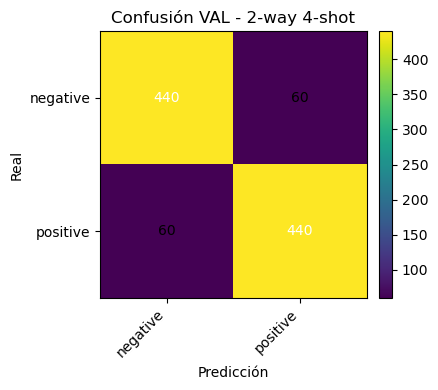

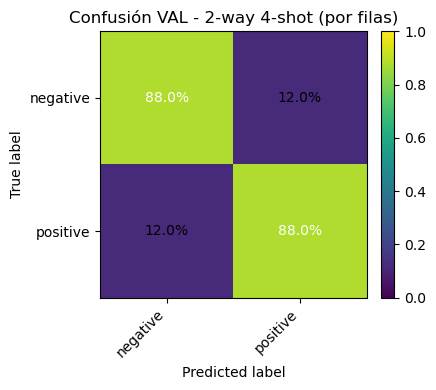

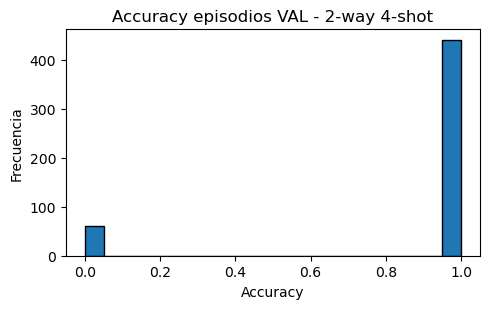

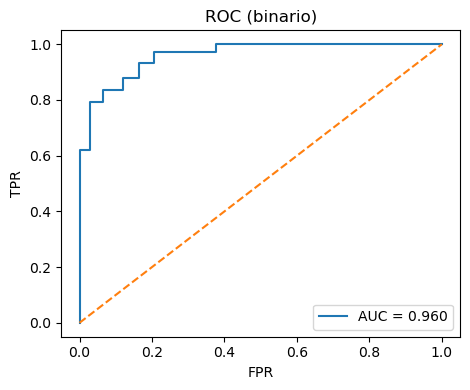

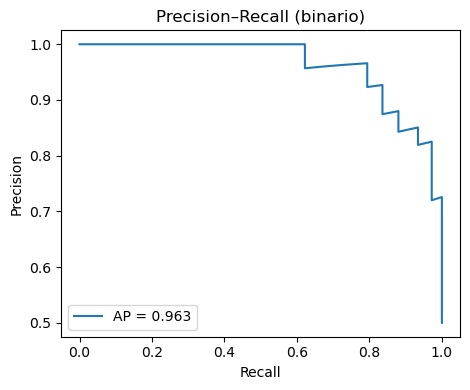

Umbral ~95% espec (VAL): {'thr': 0.681, 'sens': 0.794, 'spec': 0.972}
Umbral máx F1 (VAL):      {'thr': 0.138, 'f1': 0.8925619834710744}

TEST @ thr(95spec en VAL): {'acc': np.float64(0.542), 'sens': np.float64(0.472), 'spec': np.float64(0.612), 'f1': np.float64(0.5075268817204301), 'tp': np.int64(236), 'fp': np.int64(194), 'tn': np.int64(306), 'fn': np.int64(264)}


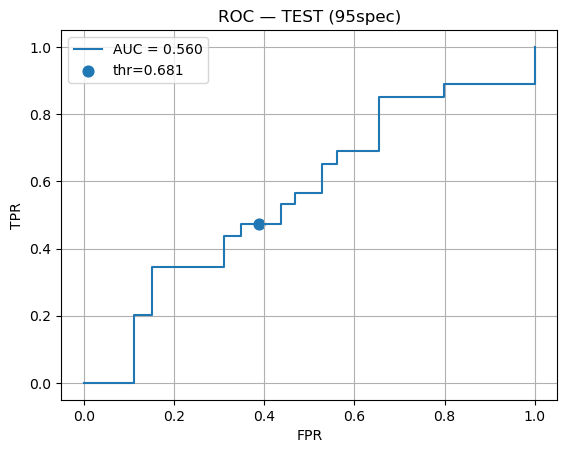

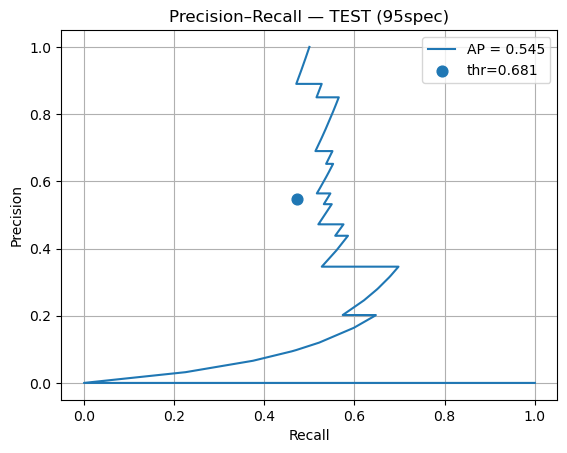

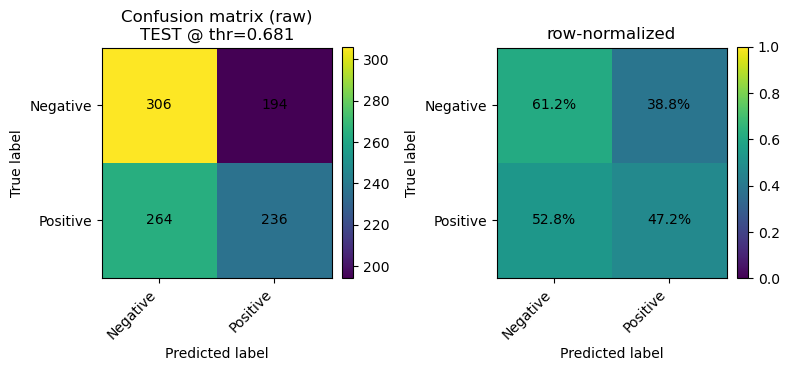


TEST @ thr(maxF1 en VAL): {'acc': np.float64(0.582), 'sens': np.float64(0.85), 'spec': np.float64(0.314), 'f1': np.float64(0.6703470031545742), 'tp': np.int64(425), 'fp': np.int64(343), 'tn': np.int64(157), 'fn': np.int64(75)}


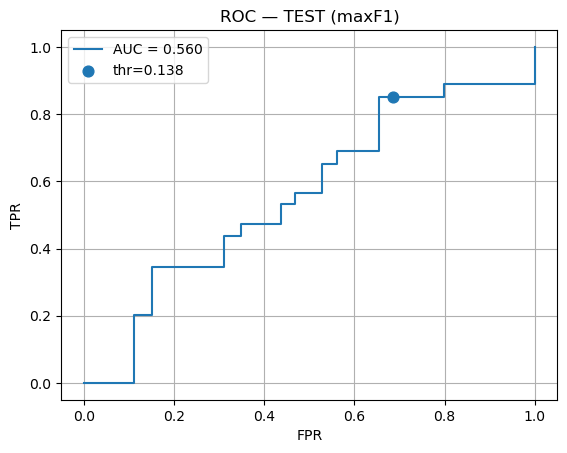

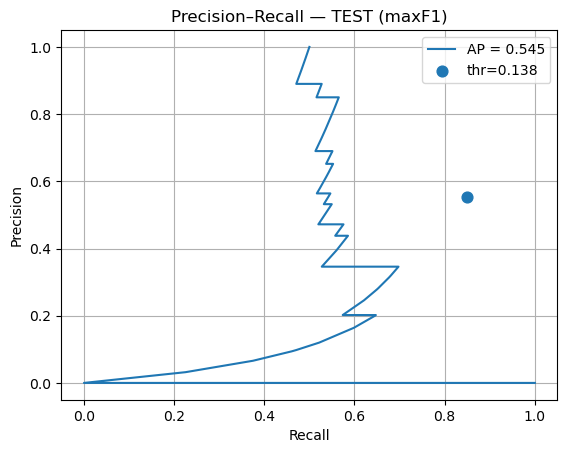

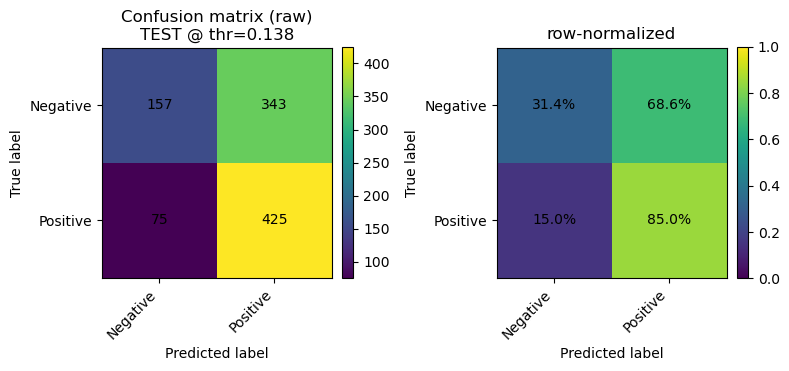

In [ ]:
fewshot_cfgs = [
    {"n_way": 2, "n_shot": 1, "n_query": 4, "n_episodes": 500},
    {"n_way": 2, "n_shot": 2, "n_query": 3, "n_episodes": 500},
    {"n_way": 2, "n_shot": 3, "n_query": 2, "n_episodes": 500},
    {"n_way": 2, "n_shot": 4, "n_query": 1, "n_episodes": 500},
]

os.makedirs(OUT_DIR, exist_ok=True)
all_runs = []

print("\n=== Few-shot evaluation (ProtoNet encoder + ProtoHead coseno) ===")
for idx, cfg in enumerate(fewshot_cfgs):
    show_plots = (idx == len(fewshot_cfgs) - 1)

    res_val  = run_fewshot_eval_PROTO(
        proto_model, val_ds,  device, **cfg, seed=123,
        proto_head=proto_head, standardize_episode=STANDARDIZE_EPISODE_EVAL
    )
    res_test = run_fewshot_eval_PROTO(
        proto_model, test_ds, device, **cfg, seed=456,
        proto_head=proto_head, standardize_episode=STANDARDIZE_EPISODE_EVAL
    )

    print(f"VAL  (k={cfg['n_way']}, n={cfg['n_shot']}):",
          {k:v for k,v in res_val.items()  if isinstance(v,(int,float))})
    print(f"TEST (k={cfg['n_way']}, n={cfg['n_shot']}):",
          {k:v for k,v in res_test.items() if isinstance(v,(int,float))})
    print(f"inv_temp usado (VAL):  {res_val.get('inv_temp_used','-')}")
    print(f"inv_temp usado (TEST): {res_test.get('inv_temp_used','-')}")

    # 1) Matriz de confusión VAL
    y_true = np.array(res_val["y_true"])
    y_pred = np.array(res_val["y_pred"])
    cm = confusion_matrix(y_true, y_pred, labels=list(range(cfg["n_way"])))
    class_names = ["negative", "positive"] if cfg["n_way"] == 2 else [f"cls{i}" for i in range(cfg["n_way"])]
    title_val = f"Confusión VAL - {cfg['n_way']}-way {cfg['n_shot']}-shot"
    if show_plots:
        plot_confusion(cm, class_names, title=title_val)
        plot_confusion_percent(cm, class_names=class_names, title=f"{title_val} (por filas)", normalize="row")

    # 2) Histograma de accuracies por episodio (VAL)
    if show_plots:
        plot_hist_acc(res_val["episode_accs"], title=f"Accuracy episodios VAL - {cfg['n_way']}-way {cfg['n_shot']}-shot")

    # 3) ROC / PR en VAL (binario)
    if show_plots and cfg["n_way"] == 2 and "pos_scores" in res_val:
        targets_val = (np.array(res_val["y_true"]) == 1).astype(np.int64)  # 1=positive
        plot_roc_pr(targets_val, np.array(res_val["pos_scores"]))

    # 4) Selección de umbral en VAL y aplicación en TEST (binario)
    if cfg["n_way"] == 2 and "pos_scores" in res_val and "pos_scores" in res_test:
        scores_val = np.array(res_val["pos_scores"])
        targets_val = (np.array(res_val["y_true"]) == 1).astype(np.int64)  # positivo = índice episódico 1
        scores_test = np.array(res_test["pos_scores"])
        targets_test = (np.array(res_test["y_true"]) == 1).astype(np.int64)

        opt_spec = find_threshold_for_spec(scores_val, targets_val, target_spec=0.95)
        opt_f1   = find_threshold_max_f1(scores_val, targets_val)
        print("Umbral ~95% espec (VAL):", opt_spec)
        print("Umbral máx F1 (VAL):     ", opt_f1)

        for name, thr in [("95spec", opt_spec["thr"]), ("maxF1", opt_f1["thr"])]:
            print(f"\nTEST @ thr({name} en VAL):", evaluate_with_threshold(scores_test, targets_test, thr))

            if show_plots:
                # ROC/PR + CM para TEST
                auc_val = roc_auc_score(targets_test, scores_test)
                ap_val  = average_precision_score(targets_test, scores_test)
                preds = (scores_test >= thr).astype(np.int64)
                tn, fp, fn, tp = confusion_matrix(targets_test, preds, labels=[0,1]).ravel()
                tpr_point = tp / (tp + fn) if (tp+fn)>0 else 0.0
                fpr_point = fp / (fp + tn) if (fp+tn)>0 else 0.0
                prec_point = tp / (tp + fp) if (tp+fp)>0 else 0.0

                # ROC
                fpr, tpr, _ = roc_curve(targets_test, scores_test)
                plt.figure()
                plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
                plt.scatter([fpr_point],[tpr_point], s=60, marker='o', label=f"thr={thr:.3f}")
                plt.xlabel("FPR")
                plt.ylabel("TPR")
                plt.title(f"ROC — TEST ({name})")
                plt.grid(True)
                plt.legend()
                plt.savefig(os.path.join(OUT_DIR, f"roc_test_{cfg['n_shot']}shot_{name}.png"), bbox_inches='tight', dpi=150)
                plt.show()

                # PR
                rec, prec, _ = precision_recall_curve(targets_test, scores_test)
                plt.figure()
                plt.plot(rec, prec, label=f"AP = {ap_val:.3f}")
                plt.scatter([tpr_point],[prec_point], s=60, marker='o', label=f"thr={thr:.3f}")
                plt.xlabel("Recall")
                plt.ylabel("Precision")
                plt.title(f"Precision–Recall — TEST ({name})")
                plt.grid(True)
                plt.legend()
                plt.savefig(os.path.join(OUT_DIR, f"pr_test_{cfg['n_shot']}shot_{name}.png"), bbox_inches='tight', dpi=150)
                plt.show()

                # Matrices de confusión
                cm = confusion_matrix(targets_test, preds, labels=[0,1])
                cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True).clip(min=1)
                fig, axes = plt.subplots(1, 2, figsize=(8, 3.8))

                ax = axes[0]
                im = ax.imshow(cm, interpolation='nearest')
                ax.set_title(f"Confusion matrix (raw)\nTEST @ thr={thr:.3f}")
                ax.set_xticks([0,1])
                ax.set_yticks([0,1])
                ax.set_xticklabels(['Negative','Positive'])
                ax.set_yticklabels(['Negative','Positive'])
                plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
                for i in range(cm.shape[0]):
                    for j in range(cm.shape[1]):
                        ax.text(j, i, int(cm[i, j]), ha="center", va="center")
                ax.set_ylabel('True label')
                ax.set_xlabel('Predicted label')
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

                ax = axes[1]
                im2 = ax.imshow(cm_norm, interpolation='nearest', vmin=0, vmax=1)
                ax.set_title("row-normalized")
                ax.set_xticks([0,1])
                ax.set_yticks([0,1])
                ax.set_xticklabels(['Negative','Positive'])
                ax.set_yticklabels(['Negative','Positive'])
                plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
                for i in range(cm_norm.shape[0]):
                    for j in range(cm_norm.shape[1]):
                        ax.text(j, i, f"{cm_norm[i,j]*100:.1f}%", ha="center", va="center")
                ax.set_ylabel('True label')
                ax.set_xlabel('Predicted label')
                plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)

                plt.tight_layout()
                plt.savefig(os.path.join(OUT_DIR, f"cm_test_{cfg['n_shot']}shot_{name}.png"), bbox_inches='tight', dpi=150)
                plt.show()

    all_runs.append({"cfg": cfg, "val": res_val, "test": res_test})

with open(os.path.join(OUT_DIR, "fewshot_results_proto.json"), "w") as f:
    json.dump(all_runs, f, indent=2)